<a href="https://colab.research.google.com/github/otsuka-shigenori/da_demo/blob/master/da_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

このノートブックではデータ同化の基礎的なアルゴリズムを示します。

1. 実験に使うカオス力学系のモデルを用意
2. 拡張カルマンフィルタの実装
3. アンサンブルカルマンフィルタを摂動観測法で実装
4. アンサンブルカルマンフィルタをLETKFで実装

まずはライブラリの読み込みを行います。

In [0]:
import math                              # 数学ライブラリ
import numpy as np                       # 数値計算用の配列
import numpy.linalg as LA                # 行列計算ライブラリ
import matplotlib.pyplot as plt          # 可視化ライブラリ

Lorenz and Emanuel (1998, <i>Journal of the Atmospheric Science</i>)のカオス力学系を題材にします。

地球を東西に一周する大気の変動を模したモデルです。
モデルの方程式は以下で与えられます。

dx<sub>j</sub>/dt = (x<sub>j+1</sub> - x<sub>j-2</sub>)x<sub>j-1</sub> - x<sub>j</sub> + F

j = 1, ..., n, 周期境界条件

第一項は波動の伝播、第二項はエネルギー減衰、第三項のFは外部強制力を模していて、Fが4以上になると徐々に非周期解に遷移し、Fが大きいほどカオス的に振る舞います。

通常、n = 40 を使います。以下の実験では F = 8 とします。

以下、時刻 i の x<sub>j</sub>, j = 1, ..., n をまとめて x<sub>i</sub> と表します。

In [0]:
class Lorenz96:
  """
  This class provides the Lorenz96 model equations and the 4th-order Runge-Kutta solver.
  """
  def __init__(self, n = 40, f = 8, dt = 0.005, init_x = None):
    self.f = f
    self.dt = dt
    if init_x is not None:
      self.x = init_x
    else:
      self.x = np.zeros(n, dtype=np.float64)
    # temporary memory
    self.tmpx = np.zeros(n + 3, dtype=np.float64)
    self.tmpdx = np.zeros(n, dtype=np.float64)
    return
  
  def dx_dt(self, y):
    n = y.shape[0]
    m = n + 3
    self.tmpx[2:(m - 1)] = y[:]
    # cyclic boundary condition
    self.tmpx[0:2] = y[(n - 2):n]
    self.tmpx[m - 1] = y[0]
    #self.tmpdx = (self.tmpx[3:m] - self.tmpx[0:(m - 3)]) * self.tmpx[1:(m - 2)] - self.tmpx[2:(m - 1)] + self.f
    self.tmpdx[:] = self.tmpx[3:m]
    self.tmpdx   -= self.tmpx[0:(m - 3)]
    self.tmpdx   *= self.tmpx[1:(m - 2)]
    self.tmpdx   -= self.tmpx[2:(m - 1)]
    self.tmpdx   += self.f
    return self.tmpdx

  def runge_kutta(self):
    dx1 = self.dx_dt(self.x)
    x1  = self.x + dx1 * (self.dt * 0.5)
    dx2 = self.dx_dt(x1)
    x2  = self.x + dx2 * (self.dt * 0.5)
    dx3 = self.dx_dt(x2)
    x3  = self.x + dx3 * self.dt
    dx4 = self.dx_dt(x3)
    self.x += (dx1 + 2.0 * (dx2 + dx3) + dx4) * (self.dt / 6.0)
    return self.x


以下で使うモデルのサイズをここで設定しておきます。もし実行が遅いと感じる場合は、n = 20 などに減らしてみて下さい。

In [0]:
# model size
n = 40

適当な乱数を初期値に与えてモデルを実行し、真値とします。

真値に正規乱数を加えて疑似観測データを生成します。

疑似観測データを別のモデル（同じでも良い）でデータ同化する実験を行います。

Observing System Simulation Experiment (OSSE)と呼びます。

真値  x<sup>t</sup><sub>i</sub> を作成します。

In [37]:
exp_length = 40 * 365

x0 = np.array(np.random.randn(n), dtype=np.float64)
l96 = Lorenz96(n, init_x = x0)
nature = []
for i in range(exp_length):
  nature.append(l96.runge_kutta().copy())
nature = np.array(nature, dtype=np.float64)

print(nature.shape)


(14600, 40)


作成した真値を可視化してみます

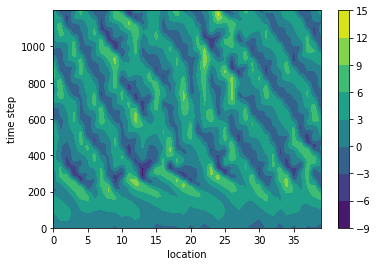

In [38]:
plt.contourf(nature[0:(40 * 30), :])
plt.xlabel('location')
plt.ylabel('time step')
plt.colorbar()

カオス力学系であることを見てみましょう。真値に途中で微小擾乱を与えて、続きを計算してみます。両者の差の時間変化を見てみます。

Text(0, 0.5, 'root mean square error')

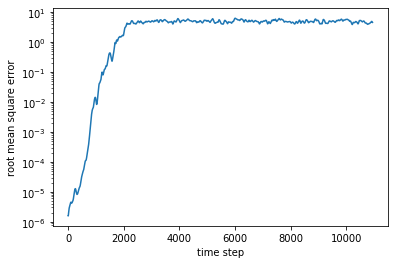

In [39]:
iter_pert = 10 * 365

xpert = nature[iter_pert].copy()
xpert[0] += 1.0e-5
l96 = Lorenz96(n, init_x = xpert)
perturbed = [xpert.copy()]
t = [0]
for i in range(exp_length - iter_pert - 1):
  perturbed.append(l96.runge_kutta().copy())
  t.append(i)
perturbed = np.array(perturbed, dtype=np.float64)

diff = perturbed - nature[iter_pert:]
rmse = np.sqrt(np.sum(diff * diff, 1) / n)

plt.plot(t, rmse)
plt.yscale('log')
plt.xlabel('time step')
plt.ylabel('root mean square error')

最初はroot mean square errorが指数関数的に増大していきます。あるところまで増大すると、誤差の非線形性が卓越してきて、誤差の振幅が飽和します。

データ同化実験の準備をします。

真値に平均0、分散1の正規乱数を加えて疑似観測 y<sup>o</sup><sub>i</sub> を作成します

In [0]:
obs_err_std = 1.0
obs = nature + np.random.randn(nature.shape[0], nature.shape[1]) * obs_err_std

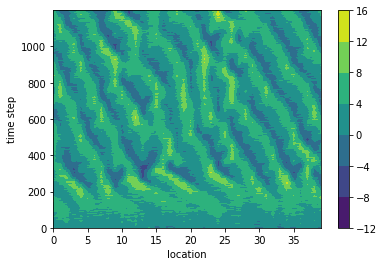

In [41]:
plt.contourf(obs[0:(40 * 30), :])
plt.xlabel('location')
plt.ylabel('time step')
plt.colorbar()

最初の方はモデルが十分に落ち着いていないので捨てます。

In [0]:
n_spinup = 40 * 30
nature = nature[n_spinup:]
obs = obs[n_spinup:]
exp_length -= n_spinup

拡張カルマンフィルタを構築します。以下の式で与えられます。

1. 時刻 i から i + 1 への予報：

x<sup>f</sup><sub>i + 1</sub> = m(x<sup>a</sup><sub>i</sub>) ：状態変数の予報

M<sub>i</sub> = (∂m/∂x)|<sub>(x<sup>a</sup><sub>i</sub></sub>, <sub>x<sup>f</sup><sub>i + 1</sub>)</sub> ：接線型モデル

P<sup>f</sup><sub>i + 1</sub> = M<sub>i</sub>P<sup>a</sup><sub>i</sub>M<sup>T</sup><sub>i</sub> ：予報誤差共分散

2. 時刻 i での解析：

y<sup>o</sup><sub>i</sub> ：観測データ

y<sup>f</sup><sub>i</sub> = h<sub>i</sub>(x<sup>f</sup><sub>i</sub>) ：モデル状態変数 x<sup>f</sup><sub>i</sub> から観測相当量 y<sup>f</sup><sub>i</sub> への写像（観測演算子）

H<sub>i</sub> ：観測演算子の接線形近似（以下では観測演算子が線形と仮定して h<sub>i</sub> をそのまま使用）

R<sub>i</sub> ：観測誤差共分散（独立性が仮定できれば対角行列）

K<sub>i</sub> = P<sup>f</sup><sub>i</sub> H<sup>T</sup><sub>i</sub> (H<sub>i</sub> P<sup>f</sup><sub>i</sub> H<sup>T</sup><sub>i</sub> + R<sub>i</sub>)<sup>-1</sup> ：カルマンゲイン

x<sup>a</sup><sub>i</sub> = x<sup>f</sup><sub>i</sub> + K<sub>i</sub> (y<sup>o</sup><sub>i</sub> - y<sup>f</sup><sub>i</sub>) ：状態変数の解析

P<sup>a</sup><sub>i</sub> = (I - K<sub>i</sub>H<sub>i</sub>)P<sup>f</sup><sub>i</sub> ：解析誤差共分散

In [0]:
class KalmanFilter:
  def __init__(self, model, n = 40, f = 8, dt = 0.005):
    """
    model: model constructor
    n: model size
    f: external forcing
    dt: time interval of model time integration
    n, f, dt will be passed to the model constructor
    """
    self.n = n
    self.f = f
    self.dt = dt
    # model for the state
    self.model = model(n, f, dt)
    # models to approximate tangent linear model
    self.ensemble = []
    for i in range(n):
      self.ensemble.append(model(n, f, dt))
    # background error covariance matrix
    self.p_f = np.identity(n, dtype=np.float64)
    return
  
  def forward(self):
    """
    This function updates the model state and the background error covariance matrix.
    """
    tmpx = self.model.x.copy()
    # update state
    self.model.runge_kutta()
    # approximate tangent linear model
    eps = 1.0e-8
    m = np.zeros_like(self.p_f)
    for i in range(self.n):
      self.ensemble[i].x[:] = tmpx[:]
      self.ensemble[i].x[i] += eps
      self.ensemble[i].runge_kutta()
      m[:, i] = self.ensemble[i].x[:]
    m -= self.model.x[:, np.newaxis]
    m /= eps
    # update background error covariance matrix
    self.p_f = m @ self.p_f @ (m.T)
    return self.model.x, self.p_f

  def analysis(self, h, y, r):
    """
    This function performs the Kalman filtering.
    h: observation operator matrix
    y: a vector of observations
    r: observation error covariance matrix
    """
    if len(self.model.x.shape) == 1:
      xx = self.model.x[:, np.newaxis]
    else:
      xx = self.model.x
    if len(y.shape) == 1:
      yy = y[:, np.newaxis]
    else:
      yy = y
    kalman_gain = self.p_f @ (h.T) @ LA.inv(h @ self.p_f @ (h.T) + r)
    xx += kalman_gain @ (yy - h @ xx)
    self.p_f = (np.identity(self.n, dtype=np.float64) - kalman_gain @ h) @ self.p_f
    return self.model.x, self.p_f

データ同化サイクルを回してみます。

n = 40 として、40点すべてを観測するとします。
データ同化の頻度は、モデルの時間積分10ステップに1回とします。

状態変数の初期値は 0、予報誤差共分散行列の初期値は単位行列にしています。

（Lorenz96モデルはF=8の時に、0.4無次元時間で誤差が約2倍になります。地球大気では大規模波動（温帯低気圧など）の誤差が2日で倍になる傾向があるため、ここでは0.2無次元時間を1日と考え、通常の気象観測と同様に1日4回観測することにします。）

In [44]:
kf = KalmanFilter(Lorenz96, n)
# set observation error covariance matrix (diagonal)
r = np.identity(n, dtype=np.float64) * obs_err_std
# set observation operator matrix (use identity)
h = np.identity(n, dtype=np.float64)
x = []
analysis_intv = 10

# MAIN LOOP
for i in range(exp_length // analysis_intv):
  for j in range(analysis_intv):
    # time (i * analysis_intv + j) to (i * analysis_intv + j + 1)
    xf, pf = kf.forward()
  if (i + 1) * analysis_intv < exp_length:
    if i % 100 == 0:
      print("analysis ", i)
    else:
      print(".", end="")
    xa, pa = kf.analysis(h, obs[(i + 1) * analysis_intv, :], r)
    x.append(((i + 1) * analysis_intv, xa.copy()))
print("done")

analysis  0
...................................................................................................analysis  100
...................................................................................................analysis  200
...................................................................................................analysis  300
...................................................................................................analysis  400
...................................................................................................analysis  500
...................................................................................................analysis  600
...................................................................................................analysis  700
...................................................................................................analysis  800
....................................................................................

うまく動いたか、確認します。真値とのずれをroot mean square errorの時系列で見てみます。

観測誤差を1.0としているので、それより大きいか小さいか確認します。

Text(0, 0.5, 'root mean square error')

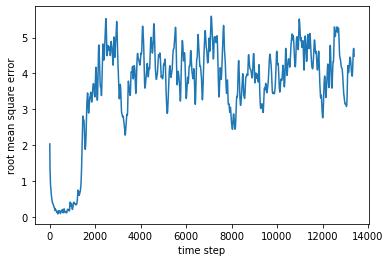

In [45]:
rmse = []
for xx in x:
  if xx[0] < nature.shape[0]:
    rmse.append((xx[0], math.sqrt(((nature[xx[0]] - xx[1]) ** 2).sum() / n)))
rmse = np.array(rmse) 

plt.plot(rmse[:, 0], rmse[:, 1])
plt.xlabel('time step')
plt.ylabel('root mean square error')

最初はうまく動いているように見えますが、途中から悪くなっているのが分かるかと思います。

これは、非線形モデルに対して接線形近似を行って線形最適化問題を解いているため、予報誤差共分散が過小評価される傾向にあるためです。

対策として、予報誤差共分散を人工的に膨張させます（誤差共分散膨張）。

In [46]:
kf = KalmanFilter(Lorenz96, n)
# set observation error covariance matrix (diagonal)
r = np.identity(n, dtype=np.float64) * obs_err_std
# set observation operator matrix (use identity)
h = np.identity(n, dtype=np.float64)
x_new = []
pa_hist = []
analysis_intv = 10

# MAIN LOOP
for i in range(exp_length // analysis_intv):
  for j in range(analysis_intv):
    # time (i * analysis_intv + j) to (i * analysis_intv + j + 1)
    xf, pf = kf.forward()
  if (i + 1) * analysis_intv < exp_length:
    if i % 100 == 0:
      print("analysis ", i)
    else:
      print(".", end="")
    # multiplicative covariance inflation
    kf.p_f *= 1.1
    #
    xa, pa = kf.analysis(h, obs[(i + 1) * analysis_intv, :], r)
    x_new.append(((i + 1) * analysis_intv, xa.copy()))
    pa_hist.append(pa.copy())
pa_mean = np.mean(np.array(pa_hist), 0)
print("done")

analysis  0
...................................................................................................analysis  100
...................................................................................................analysis  200
...................................................................................................analysis  300
...................................................................................................analysis  400
...................................................................................................analysis  500
...................................................................................................analysis  600
...................................................................................................analysis  700
...................................................................................................analysis  800
....................................................................................

結果を確認します。

Text(0, 0.5, 'root mean square error')

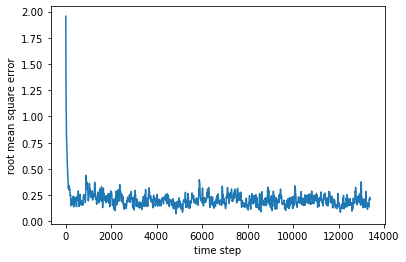

In [47]:
rmse = []
for xx in x_new:
  if xx[0] < nature.shape[0]:
    rmse.append((xx[0], math.sqrt(((nature[xx[0]] - xx[1]) ** 2).sum() / n)))
rmse = np.array(rmse) 

plt.plot(rmse[:, 0], rmse[:, 1])
plt.xlabel('time step')
plt.ylabel('root mean square error')

誤差が低く抑えられていることが分かります。

Lorenz96モデルでカルマンフィルタを動かすと、観測誤差の標準偏差が1.0の場合は、解析root mean square errorは約0.2になります。

つまり、観測誤差よりも解析誤差を小さくすることが出来ます。

次に、カルマンフィルタの肝である、誤差共分散行列を見てみます。まずは瞬間値です。

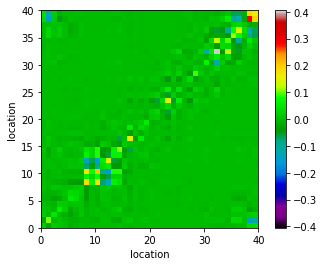

In [48]:
max = np.max(np.abs(kf.p_f))
plt.pcolormesh(kf.p_f, cmap="nipy_spectral", vmin=-max, vmax=max)
plt.gca().set_aspect('equal')
plt.xlabel('location')
plt.ylabel('location')
plt.colorbar()

時間平均したものも見てみます。

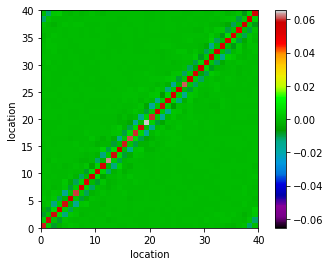

In [49]:
max = np.max(np.abs(pa_mean))
plt.pcolormesh(pa_mean, cmap="nipy_spectral", vmin=-max, vmax=max)
plt.gca().set_aspect('equal')
plt.xlabel('location')
plt.ylabel('location')
plt.colorbar()

対称行列で、非対角成分はほとんどの場所で小さいですが、対角成分とその周辺に構造が見えます。

元の予報方程式では、自分の点の前後2点先までを含む式になっています。そのため、対角成分から二つ隣まで、大きな値が入る傾向があります。

この構造が、時々刻々と変化します。それに応じて観測の情報を最適に取り込むことで、精度の高い解析を実現します。

この行列の大きさは、元のモデルの次元の二乗になります。低次元のシステムでは陽に行列を持つことが出来ますが、大次元のシステムでは行列が計算機のメモリーに乗らなくなります。

大次元システムにカルマンフィルタを適用する場合には、予報誤差共分散行列を陽に持たず、摂動を加えたシミュレーションを多数実行して変数間の相関を見積もる、アンサンブルカルマンフィルタが用いられます。

実装方法は複数ありますが、大別すると以下の二つです：


1.   摂動観測法　Perturbed Observation (PO) method
2.   平方根フィルタ　Square root filter (SRF)

平方根フィルタはさらに多数の実装方法に細分化されます。

PO法の式は以下で与えられます。

1. 時刻 i から i + 1 への予報：

x<sup>f(k)</sup><sub>i + 1</sub> = m(x<sup>a(k)</sup><sub>i</sub>) ：状態変数のアンサンブル予報 (k = 1, ..., K)

2. 時刻 i でのアンサンブル平均場の解析：

x<sup>f</sup><sub>i + 1</sub> = (1 / K) Σ<sub>k = 1,...,K</sub> x<sup>f(k)</sup><sub>i + 1</sub> ：アンサンブル平均場

dx<sup>(k)</sup> = x<sup>f(k)</sup><sub>i + 1</sub> - x<sup>f</sup><sub>i + 1</sub> ：アンサンブル摂動

Z<sub>i + 1</sub> = (1/sqrt(K - 1)) (dx<sup>(1)</sup>, dx<sup>(2)</sup>, ..., dx<sup>(K)</sup>) ：アンサンブル摂動の列ベクトルを束ねた行列

P<sup>f</sup><sub>i + 1</sub> = Z<sub>i + 1</sub> Z<sup>T</sup><sub>i + 1</sub> ：予報誤差共分散の近似（実際には解かない）

Y<sub>i + 1</sub> = H<sub>i + 1</sub> Z<sub>i + 1</sub> ：アンサンブル摂動の観測空間への写像

K<sub>i</sub> = Z<sub>i</sub> Y<sup>T</sup><sub>i</sub> (Y<sub>i</sub> Y<sup>T</sup><sub>i</sub> + R<sub>i</sub>)<sup>-1</sup> ：カルマンゲイン

x<sup>a</sup><sub>i</sub> = x<sup>f</sup><sub>i</sub> + K<sub>i</sub> (y<sup>o</sup><sub>i</sub> - H<sub>i</sub> x<sup>f</sup><sub>i</sub>) ：状態変数の解析

3. 時刻 i での各アンサンブルメンバーの解析：

σ<sup>o</sup> ：観測誤差共分散 R<sub>i</sub> の対角成分の平方根

y<sup>o(k)</sup> = y<sup>o</sup> + N(0, σ<sup>o</sup>) ：観測に観測誤差相当の正規乱数を加える（各アンサンブルメンバー、各変数独立に）

x<sup>a(k)</sup><sub>i</sub> = x<sup>f(k)</sup><sub>i</sub> + K<sub>i</sub> (y<sup>o(k)</sup><sub>i</sub> - H<sub>i</sub> x<sup>f(k)</sup><sub>i</sub>) ：状態変数の解析


In [0]:
class EnKF_PO:
  def __init__(self, model, n = 40, f = 8, dt = 0.005, k = 20, localization = None):
    """
    model: model constructor
    n: model size
    f: external forcing
    dt: time interval of model time integration
    n, f, dt will be passed to the model constructor
    k: ensemble size
    localization: K-localization length scale (if it is not None)
    """
    self.n = n
    self.f = f
    self.dt = dt
    self.k = k
    self.localization = localization
    # models
    self.ensemble = []
    for i in range(k):
      self.ensemble.append(model(n, f, dt))
    return
  
  def forward(self):
    """
    This function updates the model state.
    """
    for i in range(self.k):
      self.ensemble[i].runge_kutta()
    return

  def mean(self):
    x_mean = self.ensemble[0].x.copy()
    for i in range(1, self.k):
      x_mean += self.ensemble[i].x
    x_mean /= self.k
    return x_mean

  def k_localization(self, h, scale):
    loc = np.zeros(h.shape[0], dtype=np.float64)
    for i in range(h.shape[0]):
      tmploc = 0
      tmpweight = 0
      for j in range(h.shape[1]):
        abs = np.abs(h[i, j])
        tmploc += j * abs
        tmpweight += abs
      loc[i] = tmploc / tmpweight
    k_loc = np.zeros_like(h.T)
    for i in range(h.shape[0]): # num of obs
      for j in range(h.shape[1]): # model size
        dist = np.min(np.mod(np.array((loc[i] - j, j - loc[i])), n))
        k_loc[j, i] = math.exp(-((dist / (math.sqrt(2) * scale)) ** 2)) # Gaussian tapering
    return k_loc

  def analysis(self, h, y, r):
    """
    This function performs the Ensemble Kalman filtering.
    h: observation operator matrix
    y: a vector of observations
    r: observation error covariance matrix
    """
    xx = self.mean()[:, np.newaxis]

    z = np.zeros((self.n, self.k), dtype=np.float64)
    for i in range(self.k):
      z[:, i] = self.ensemble[i].x
    z -= xx
    z /= math.sqrt(self.k - 1)
    hz = h @ z

    if len(y.shape) == 1:
      yy = y[:, np.newaxis]
    else:
      yy = y

    kalman_gain = z @ (hz.T) @ LA.inv(hz @ (hz.T) + r)
    if self.localization is not None:
      kalman_gain *= self.k_localization(h, self.localization)

    # mean update
    xx += kalman_gain @ (yy - h @ xx)

    # ensemble update
    obs_err = np.zeros((y.shape[0], 1))
    for i in range(y.shape[0]):
      obs_err[i, 0] = r[i, i]
    obs_err = np.sqrt(obs_err)
    for i in range(self.k):
      x_ens = self.ensemble[i].x[:, np.newaxis]
      yy_pert = yy + np.random.randn(y.shape[0], 1) * obs_err
      x_ens += kalman_gain @ (yy_pert - h @ x_ens)

    return xx[:, 0]

アンサンブル数10で実験してみます。

アンサンブル予報の初期値は標準偏差10の正規乱数にしています。

（モデル状態変数の変動幅がそのくらいあるため。）

In [51]:
kk = 10 # ensemble size
enkf_po = EnKF_PO(Lorenz96, n, k = kk)
# initial ensemble perturbation
for i in range(kk):
  enkf_po.ensemble[i].x += np.random.randn(n) * 10.0 # approximate error of the initial state
# set observation error covariance matrix (diagonal)
r = np.identity(n, dtype=np.float64) * obs_err_std
# set observation operator matrix (use identity)
h = np.identity(n, dtype=np.float64)
x_po10 = []
analysis_intv = 10

# MAIN LOOP
for i in range(exp_length // analysis_intv):
  for j in range(analysis_intv):
    # time (i * analysis_intv + j) to (i * analysis_intv + j + 1)
    xf = enkf_po.forward()
  if (i + 1) * analysis_intv < exp_length:
    if i % 100 == 0:
      print("analysis ", i)
    else:
      print(".", end="")
    # multiplicative covariance inflation
    x_mean = enkf_po.mean()
    for ii in range(kk):
      enkf_po.ensemble[ii].x = x_mean + (enkf_po.ensemble[ii].x - x_mean) * math.sqrt(1.1)
    #
    xa = enkf_po.analysis(h, obs[(i + 1) * analysis_intv, :], r)
    x_po10.append(((i + 1) * analysis_intv, xa))
print("done")

analysis  0
...................................................................................................analysis  100
...................................................................................................analysis  200
...................................................................................................analysis  300
...................................................................................................analysis  400
...................................................................................................analysis  500
...................................................................................................analysis  600
...................................................................................................analysis  700
...................................................................................................analysis  800
....................................................................................

結果はどうでしょうか。

Text(0, 0.5, 'root mean square error')

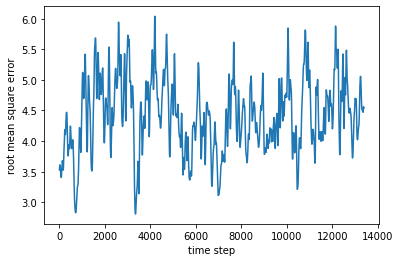

In [52]:
rmse = []
for xx in x_po10:
  if xx[0] < nature.shape[0]:
    rmse.append((xx[0], math.sqrt(((nature[xx[0]] - xx[1]) ** 2).sum() / n)))
rmse = np.array(rmse) 

plt.plot(rmse[:, 0], rmse[:, 1])
plt.xlabel('time step')
plt.ylabel('root mean square error')

アンサンブル数が少ないと、一般にうまく動かないです。

アンサンブルカルマンフィルタは、アンサンブルメンバー間の相関を使って予報誤差共分散を近似します（モンテカルロ近似）。アンサンブル数が少ないと、サンプリング誤差が大きくなります。

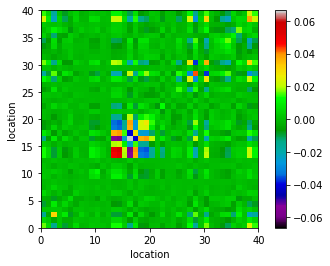

In [53]:
xx = enkf_po.mean()[:, np.newaxis]

z = np.zeros((enkf_po.n, enkf_po.k), dtype=np.float64)
for i in range(enkf_po.k):
  z[:, i] = enkf_po.ensemble[i].x
z -= xx
z /= math.sqrt(enkf_po.k - 1)
p_f = z @ (z.T)

max = np.max(np.abs(p_f))
plt.pcolormesh(p_f, cmap="nipy_spectral", vmin=-max, vmax=max)
plt.gca().set_aspect('equal')
plt.xlabel('location')
plt.ylabel('location')
plt.colorbar()

サンプリング誤差を抑えるため、予報誤差共分散の局所化を行います。

物理的に相関が無いと考えられる変数間（例えば遠く離れた点同士）の相関を人為的に低下させます。

ここでは距離に応じて正規分布で減衰させます。

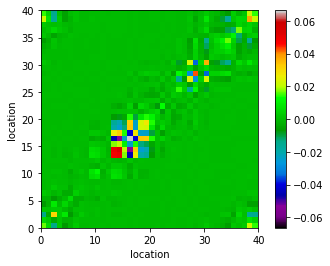

In [54]:
scale = 5.0 # localization length scale
for i in range(enkf_po.n - 1):
  for j in range(i + 1, enkf_po.n):
    dist = np.min(np.mod(np.array((j - i, i - j)), n))
    p_f[i, j] *= math.exp(-((dist / (math.sqrt(2) * scale)) ** 2)) # Gaussian tapering
    p_f[j, i] = p_f[i, j]

max = np.max(np.abs(p_f))
plt.pcolormesh(p_f, cmap="nipy_spectral", vmin=-max, vmax=max)
plt.gca().set_aspect('equal')
plt.xlabel('location')
plt.ylabel('location')
plt.colorbar()

予報誤差共分散行列を陽に解かないアンサンブルカルマンフィルタの実装においては、近似的に実装されます。カルマンゲインを調節する方法と、観測誤差を調整する方法があります。ここではカルマンゲインを調節します。

In [55]:
kk = 10 # ensemble size
scale = 3 # localization scale
enkf_po = EnKF_PO(Lorenz96, n, k = kk, localization = scale)
# initial ensemble perturbation
for i in range(kk):
  enkf_po.ensemble[i].x += np.random.randn(n) * 10.0 # approximate error of the initial state
# set observation error covariance matrix (diagonal)
r = np.identity(n, dtype=np.float64) * obs_err_std
# set observation operator matrix (use identity)
h = np.identity(n, dtype=np.float64)
x_po10loc = []
analysis_intv = 10

# MAIN LOOP
for i in range(exp_length // analysis_intv):
  for j in range(analysis_intv):
    # time (i * analysis_intv + j) to (i * analysis_intv + j + 1)
    xf = enkf_po.forward()
  if (i + 1) * analysis_intv < exp_length:
    if i % 100 == 0:
      print("analysis ", i)
    else:
      print(".", end="")
    # multiplicative covariance inflation
    x_mean = enkf_po.mean()
    for ii in range(kk):
      enkf_po.ensemble[ii].x = x_mean + (enkf_po.ensemble[ii].x - x_mean) * math.sqrt(1.1)
    #
    xa = enkf_po.analysis(h, obs[(i + 1) * analysis_intv, :], r)
    x_po10loc.append(((i + 1) * analysis_intv, xa))
print("done")

analysis  0
...................................................................................................analysis  100
...................................................................................................analysis  200
...................................................................................................analysis  300
...................................................................................................analysis  400
...................................................................................................analysis  500
...................................................................................................analysis  600
...................................................................................................analysis  700
...................................................................................................analysis  800
....................................................................................

Text(0, 0.5, 'root mean square error')

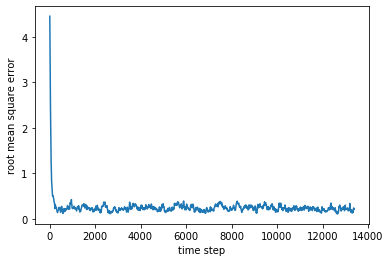

In [56]:
rmse = []
for xx in x_po10loc:
  if xx[0] < nature.shape[0]:
    rmse.append((xx[0], math.sqrt(((nature[xx[0]] - xx[1]) ** 2).sum() / n)))
rmse = np.array(rmse) 

plt.plot(rmse[:, 0], rmse[:, 1])
plt.xlabel('time step')
plt.ylabel('root mean square error')

安定して動作するようになりました。

最後に、平方根フィルタの代表例である局所アンサンブル変換カルマンフィルタ (Local Ensemble Transform Kalman Filter, LETKF)を実装します。

平方根フィルタでは、解析誤差共分散の平方根を取ることで次のステップのアンサンブル予報の初期値を得ます。この平方根の選び方は任意性があります。

dx<sup>a(k)</sup><sub>i</sub> = x<sup>a(k)</sup><sub>i</sub> - x<sup>a</sup><sub>i</sub>

dX<sup>a</sup> = (dx<sup>a(1)</sup><sub>i</sub>, dx<sup>a(2)</sup><sub>i</sub>, ..., dx<sup>a(K)</sup><sub>i</sub>)

dX<sup>a</sup> = sqrt(K - 1) (P<sup>a</sup><sub>i</sub>)<sup>1/2</sup>

LETKFでは、解析アンサンブル摂動が、予報アンサンブル摂動の線形結合で記述できると置いて、その線形変換行列 T を得ます。

dX<sup>a</sup> = dX<sup>f</sup> T

LETKFではカルマンゲインを直接計算しないため、観測誤差を調整して近似的に共分散局所化を行います。ここでは階段関数で局所化しています。すなわち、ある点から一定の距離以内にある観測だけを用いてデータ同化を行います。この操作を各点毎に独立に行います。

モデル格子点の数と同じ回数、LETKFの式を解く必要がありますが、各格子点の解析は互いに独立なため、並列計算に向いています。

In [0]:
class LETKF:
  def __init__(self, model, n = 40, f = 8, dt = 0.005, k = 20, localization = 5, inflation = 1.0):
    """
    model: model constructor
    n: model size
    f: external forcing
    dt: time interval of model time integration
    n, f, dt will be passed to the model constructor
    k: ensemble size
    localization: localization patch radius
    inflation: multiplicative covariance inflation
    """
    self.n = n
    self.f = f
    self.dt = dt
    self.k = k
    self.localization = localization
    self.infl = math.sqrt(inflation)
    # models
    self.ensemble = []
    for i in range(k):
      self.ensemble.append(model(n, f, dt))
    return
  
  def forward(self):
    """
    This function updates the model state.
    """
    for i in range(self.k):
      self.ensemble[i].runge_kutta()
    return

  def mean(self):
    x_mean = self.ensemble[0].x.copy()
    for i in range(1, self.k):
      x_mean += self.ensemble[i].x
    x_mean /= self.k
    return x_mean

  def analysis(self, h, y, r):
    """
    This function performs LETKF.
    h: observation operator matrix
    y: a vector of observations
    r: observation error covariance matrix
    """

    # forecast ensemble mean
    x = self.mean()[:, np.newaxis]
    # forecast ensemble perturbation divided by sqrt(self.k - 1)
    z = np.zeros((self.n, self.k), dtype=np.float64)
    for i in range(self.k):
      z[:, i] = self.ensemble[i].x
    z -= x
    z /= math.sqrt(self.k - 1)
    # forecast ensemble perturbation in the observation space
    hzz = h @ z

    hx0 = h @ x
    hx = np.zeros((y.shape[0], self.k), dtype=np.float64)
    for i in range(self.k):
      hx[:, i] = hx0[:, 0]
    # mismatch between the forecast ensemble mean and observation (called "innovation")
    y_hx = y[:, np.newaxis] - hx

    # analysis at each location
    for ia in range(self.n):
      x_ia = x[ia, :] # ensemble mean at this location
      z_ia = z[ia, :] # ensemble perturbation at this location

      # search local observations within the localization radius
      obs_loc = self.search_obs(ia, h)
      if len(obs_loc) == 0:
        continue
      hz_loc = hzz[obs_loc] # forecast ensemble perturbation in the observation space at this location
      y_hx_loc = y_hx[obs_loc, :] # innovation for local observations
      r_inv_loc = LA.inv(r[obs_loc, :][:, obs_loc]) # inverse of observation error covariance for local observations

      # only the value at this location is updated
      x_a = self.letkf_core(x_ia, z_ia, hz_loc, y_hx_loc, r_inv_loc)
      for i in range(self.k):
        self.ensemble[i].x[ia] = x_a[i]
    return self.mean()

  def search_obs(self, ia, h):
    patch = []
    for i in range(ia - self.localization, ia + self.localization + 1):
      patch.append(i % self.n)
    obs_loc = []
    for i in range(h.shape[0]):
      if np.max(np.abs(h[i, patch])) > 0:
        obs_loc.append(i)
    return obs_loc

  def letkf_core(self, x, z, hz, y_hx, r_inv):
    """
    x: forecast ensemble mean
    z: forecast ensemble perturbation divided by sqrt(self.k - 1)
    hz: z in the observation space
    y_hz: innovation
    r_inv: inverse of observation error covariance
    """
    # ensemble transform
    hzT_r_inv = hz.T @ r_inv
    u_d_u = hzT_r_inv @ hz
    for i in range(u_d_u.shape[0]):
      u_d_u[i, i] += 1.0
    d, u = LA.eig(u_d_u)
    d_inv = np.identity(d.shape[0], dtype=np.float64)
    d_inv_sqrt = np.identity(d.shape[0], dtype=np.float64)
    for i in range(d.shape[0]):
      d_inv[i, i] = 1.0 / d[i]
      d_inv_sqrt[i, i] = 1.0 / math.sqrt(d[i])

    w = u @ d_inv @ u.T @ hzT_r_inv @ y_hx  # mean update
    w += (u @ d_inv_sqrt @ u.T) * math.sqrt(self.k - 1) # ensemble update
    x_a = (z @ w) * self.infl + x # covariance inflation is included here
    return x_a


In [64]:
kk = 10 # ensemble size
scale = 5 # localization scale
letkf = LETKF(Lorenz96, n, k = kk, localization = scale, inflation = 1.1)
# initial ensemble perturbation
for i in range(kk):
  letkf.ensemble[i].x += np.random.randn(n) * 10.0 # approximate error of the initial state
# set observation error covariance matrix (diagonal)
r = np.identity(n, dtype=np.float64) * obs_err_std
# set observation operator matrix (use identity)
h = np.identity(n, dtype=np.float64)
x_letkf10 = []
analysis_intv = 10

# MAIN LOOP
for i in range(exp_length // analysis_intv):
  for j in range(analysis_intv):
    # time (i * analysis_intv + j) to (i * analysis_intv + j + 1)
    xf = letkf.forward()
  if (i + 1) * analysis_intv < exp_length:
    if i % 100 == 0:
      print("analysis ", i)
    else:
      print(".", end="")
    xa = letkf.analysis(h, obs[(i + 1) * analysis_intv, :], r)
    x_letkf10.append(((i + 1) * analysis_intv, xa))
print("done")

analysis  0
...................................................................................................analysis  100
...................................................................................................analysis  200
...................................................................................................analysis  300
...................................................................................................analysis  400
...................................................................................................analysis  500
...................................................................................................analysis  600
...................................................................................................analysis  700
...................................................................................................analysis  800
....................................................................................

Text(0, 0.5, 'root mean square error')

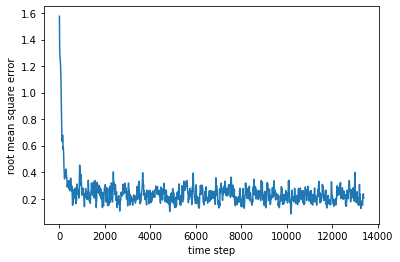

In [65]:
rmse = []
for xx in x_letkf10:
  if xx[0] < nature.shape[0]:
    rmse.append((xx[0], math.sqrt(((nature[xx[0]] - xx[1]) ** 2).sum() / n)))
rmse = np.array(rmse) 

plt.plot(rmse[:, 0], rmse[:, 1])
plt.xlabel('time step')
plt.ylabel('root mean square error')

用意してある実験はここまでです。

時間があれば、パラメータを変えて色々実験してみて下さい。